## Setting Up:

In [63]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.FranceConfig()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_orange = '#FFA500'

"""
# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
"""
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    #"aspect_sgi",  # SGI
    #"slope_sgi",  # SGI
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",  # OGGM
]

## Read in WGMS stake csv

In [ ]:
data_glacioclim = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/WGMS_all/FR_wgms_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_glacioclim['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_glacioclim[data_glacioclim.PERIOD == 'annual']) + len(data_glacioclim[data_glacioclim.PERIOD == 'winter']) + len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))



data_glacioclim.head(2)

Number of glaciers: 8
Number of winter, summer and annual samples: 10623
Number of annual samples: 4570
Number of winter samples: 3322
Number of summer samples: 2731


,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,GLACIER_ZONE,RGIId,YEAR,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
0,Argentiere_Tour_Noir_annual_smb_abl_2006_setup...,45.944607,7.024819,3033.52,20050930,20061004,-0.67,Argentiere,annual,Tour Noir,RGI60-11.03638,2006,253.839254,22.267489,3025.0,-1.019441,41.007587,5.479116
1,Argentiere_Tour_Noir_annual_smb_abl_2006_setup...,45.943724,7.022022,2941.68,20050930,20061004,-0.61,Argentiere,annual,Tour Noir,RGI60-11.03638,2006,246.198458,21.827929,2944.0,-1.244668,48.157185,2.614753


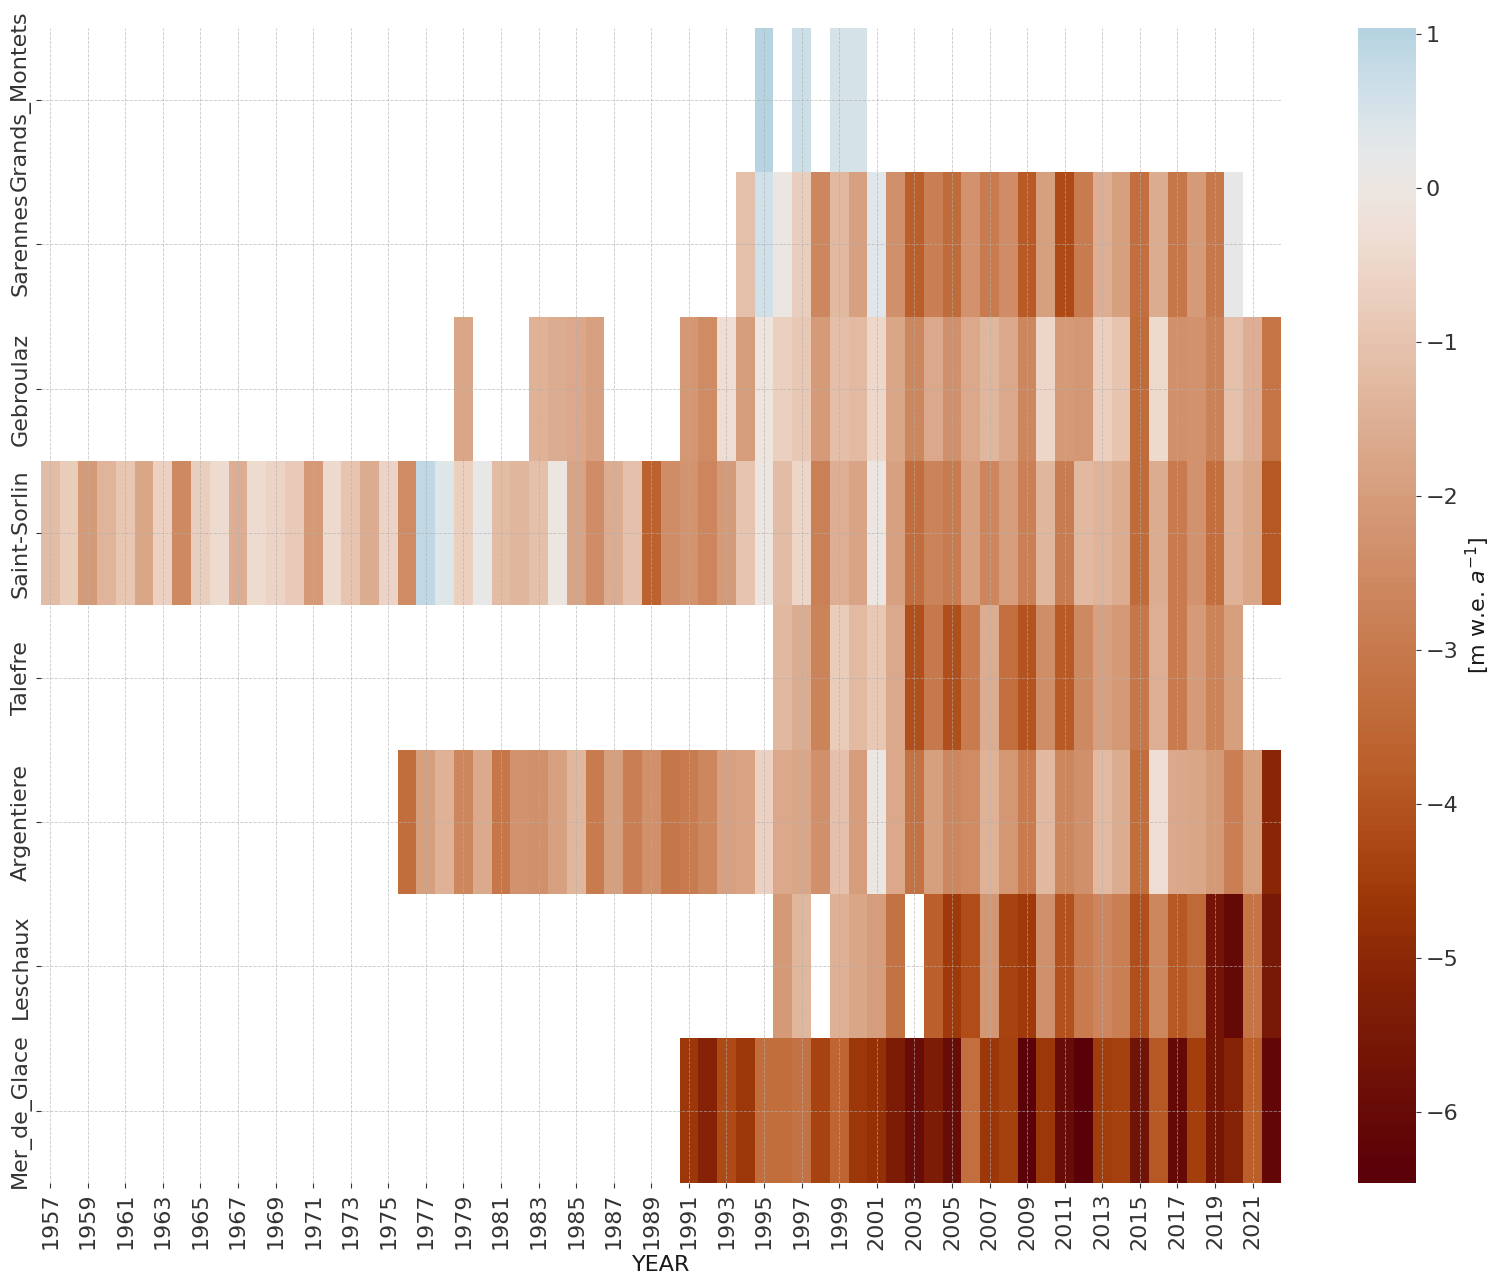

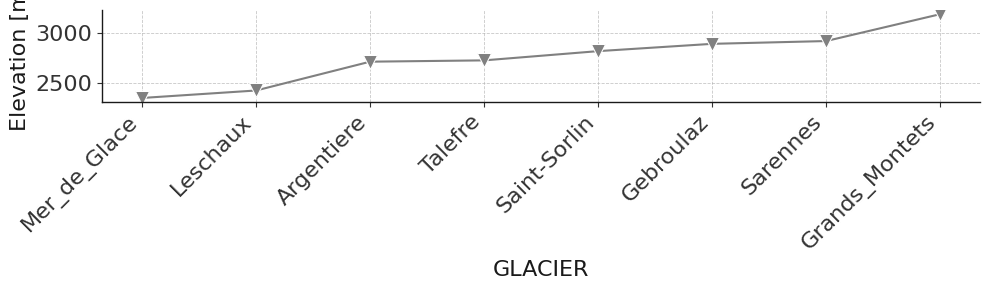

In [66]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier

mean_mb_per_glacier = data_glacioclim.copy()
mean_mb_per_glacier['YEAR'] = mean_mb_per_glacier['TO_DATE'].astype(str).str[:4].astype(int)

mean_mb_per_glacier = mean_mb_per_glacier.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] == 'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glacioclim.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 3))  # Made figure slightly taller for labels
ax = plt.subplot(1, 1, 1)
sorted_elevations = gl_per_el.sort_values(ascending=True)

sns.lineplot(sorted_elevations,
             ax=ax,
             color='gray',
             marker='v')

# Add glacier names as x-tick labels
ax.set_xticks(range(len(sorted_elevations)))
ax.set_xticklabels(sorted_elevations.index, rotation=45, ha='right')
ax.set_ylabel('Elevation [m]')
plt.tight_layout()

#### Input Dataset

In [67]:
data_glacioclim_test = data_glacioclim.copy()

print(data_glacioclim_test.shape)

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data_scratch.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure_scratch.nc'
    #'radiation_save_path': path_pcsr + 'csv/'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_glacioclim_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical)
data_monthly = dataloader_gl.data

print(data_monthly.shape)

2025-04-16 09:57:19,969 - INFO - Number of annual and seasonal samples: 10623
2025-04-16 09:57:19,971 - INFO - Running on 8 glaciers:
['Argentiere' 'Gebroulaz' 'Grands_Montets' 'Leschaux' 'Mer_de_Glace'
 'Saint-Sorlin' 'Sarennes' 'Talefre']
2025-04-16 09:57:19,988 - INFO - Number of winter, summer and annual samples: 10623
2025-04-16 09:57:19,990 - INFO - Number of annual samples: 4570
2025-04-16 09:57:19,992 - INFO - Number of winter samples: 3322
2025-04-16 09:57:19,993 - INFO - Adding climate features...


(10623, 18)


2025-04-16 09:57:31,998 - INFO - Dataset after adding climate features:
2025-04-16 09:57:32,000 - INFO - Shape: (10623, 188)
2025-04-16 09:57:32,000 - INFO - Columns: ['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE', 'RGIId', 'YEAR', 'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'u10_oct', 'u10_nov', 'u10_dec', 'u10_jan', 'u10_feb', 'u10_mar', 'u10_apr', 'u10_may', 'u10_jun', 'u10_jul', 'u10_aug', 'u10_sep', 'v10_oct', 'v10_nov', 'v10_dec', 'v10_jan', 'v10_feb', 'v10_mar', 'v10_apr', 'v10_may', 'v10_jun', 'v10_jul', 'v10_aug', 'v10_sep', 't2m_oct', 't2m_nov', 't2m_dec', 't2m_jan', 't2m_feb', 't2m_mar', 't2m_apr', 't2m_may', 't2m_jun', 't2m_jul', 't2m_aug', 't2m_sep', 'fal_oct', 'fal_nov', 'fal_dec', 'fal_jan', 'fal_feb', 'fal_mar', 'fal_apr', 'fal_may', 'fal_jun', 'fal_jul', 'fal_aug', 'fal_sep', 'snowc_oct', 'snowc_nov', 'snowc_dec', 'snowc_jan', 'snowc_feb', 'sno

(92707, 29)


In [68]:
display(data_monthly.head(2))
display('------------------')
display(data_glacioclim_test['GLACIER'].unique())
display(data_monthly['GLACIER'].unique())
display('----------LANGUE GLACIER ZONE--------')
display(data_monthly[data_monthly['GLACIER_ZONE'] == 'Langue'].head(2))

display('----------STSO------------')
display(data_monthly[data_monthly['POINT_ID'] == 'stso_annual_smb_abl_2007_setup2006_6'].head(2))

,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_setup...,0,...,5.479116,1.863512,0.002194,-1.039061e+06,-437717.194726,1.075649e+07,0.497858,-3.961348e+06,-0.321163,0.331876
1,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_setup...,0,...,5.479116,-5.253318,0.001675,-2.778184e+05,-212737.035722,7.246017e+06,0.564715,-3.621123e+06,-0.175581,0.153386


'------------------'

array(['Argentiere', 'Gebroulaz', 'Grands_Montets', 'Leschaux',
       'Mer_de_Glace', 'Saint-Sorlin', 'Sarennes', 'Talefre'],
      dtype=object)

array(['Argentiere', 'Gebroulaz', 'Grands_Montets', 'Leschaux',
       'Mer_de_Glace', 'Saint-Sorlin', 'Sarennes', 'Talefre'],
      dtype=object)

'----------LANGUE GLACIER ZONE--------'

,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
48298,1996,6.942335,45.90707,-5.49,2336.982377,-262.052377,2074.93,RGI60-11.03643,mdg_langue_annual_smb_abl_1996_setup1995_1,5598,...,27.030954,-6.309711,0.003661,-312689.854211,-337923.512459,7.617317e+06,0.561271,-3.394249e+06,-0.479726,0.192167
48299,1996,6.942335,45.90707,-5.49,2336.982377,-262.052377,2074.93,RGI60-11.03643,mdg_langue_annual_smb_abl_1996_setup1995_1,5598,...,27.030954,-9.915834,0.005198,-12605.208002,-37780.681824,5.046278e+06,0.687231,-1.889281e+06,-0.596192,0.465043


'----------STSO------------'

,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
71805,2007,6.16489,45.162951,-3.1,2001.499136,782.860864,2784.36,RGI60-11.03674,stso_annual_smb_abl_2007_setup2006_6,8068,...,6.35426,6.128460,0.002637,-3.487657e+06,-1.442510e+06,1.156050e+07,0.132249,-5.200245e+06,-0.294643,0.424080
71806,2007,6.16489,45.162951,-3.1,2001.499136,782.860864,2784.36,RGI60-11.03674,stso_annual_smb_abl_2007_setup2006_6,8068,...,6.35426,-0.426475,0.002783,-9.356324e+05,-6.593963e+05,7.509953e+06,0.326449,-4.315828e+06,-0.421494,0.361313


#### Nr. of measurements per year

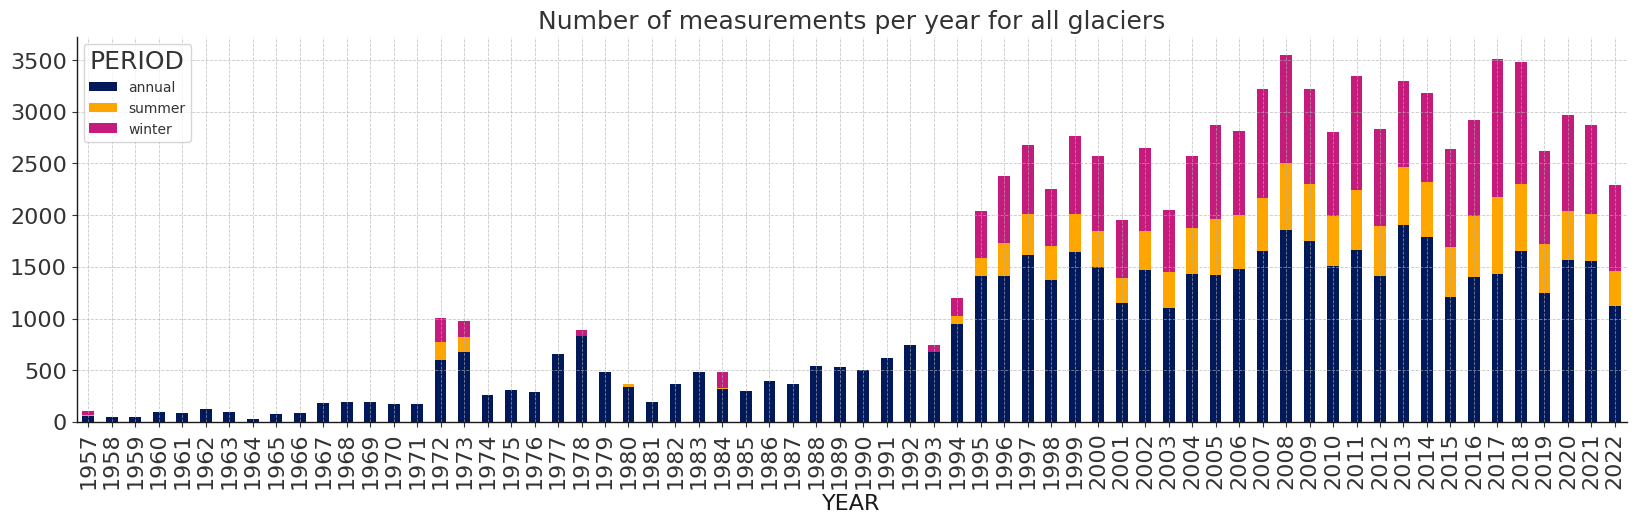

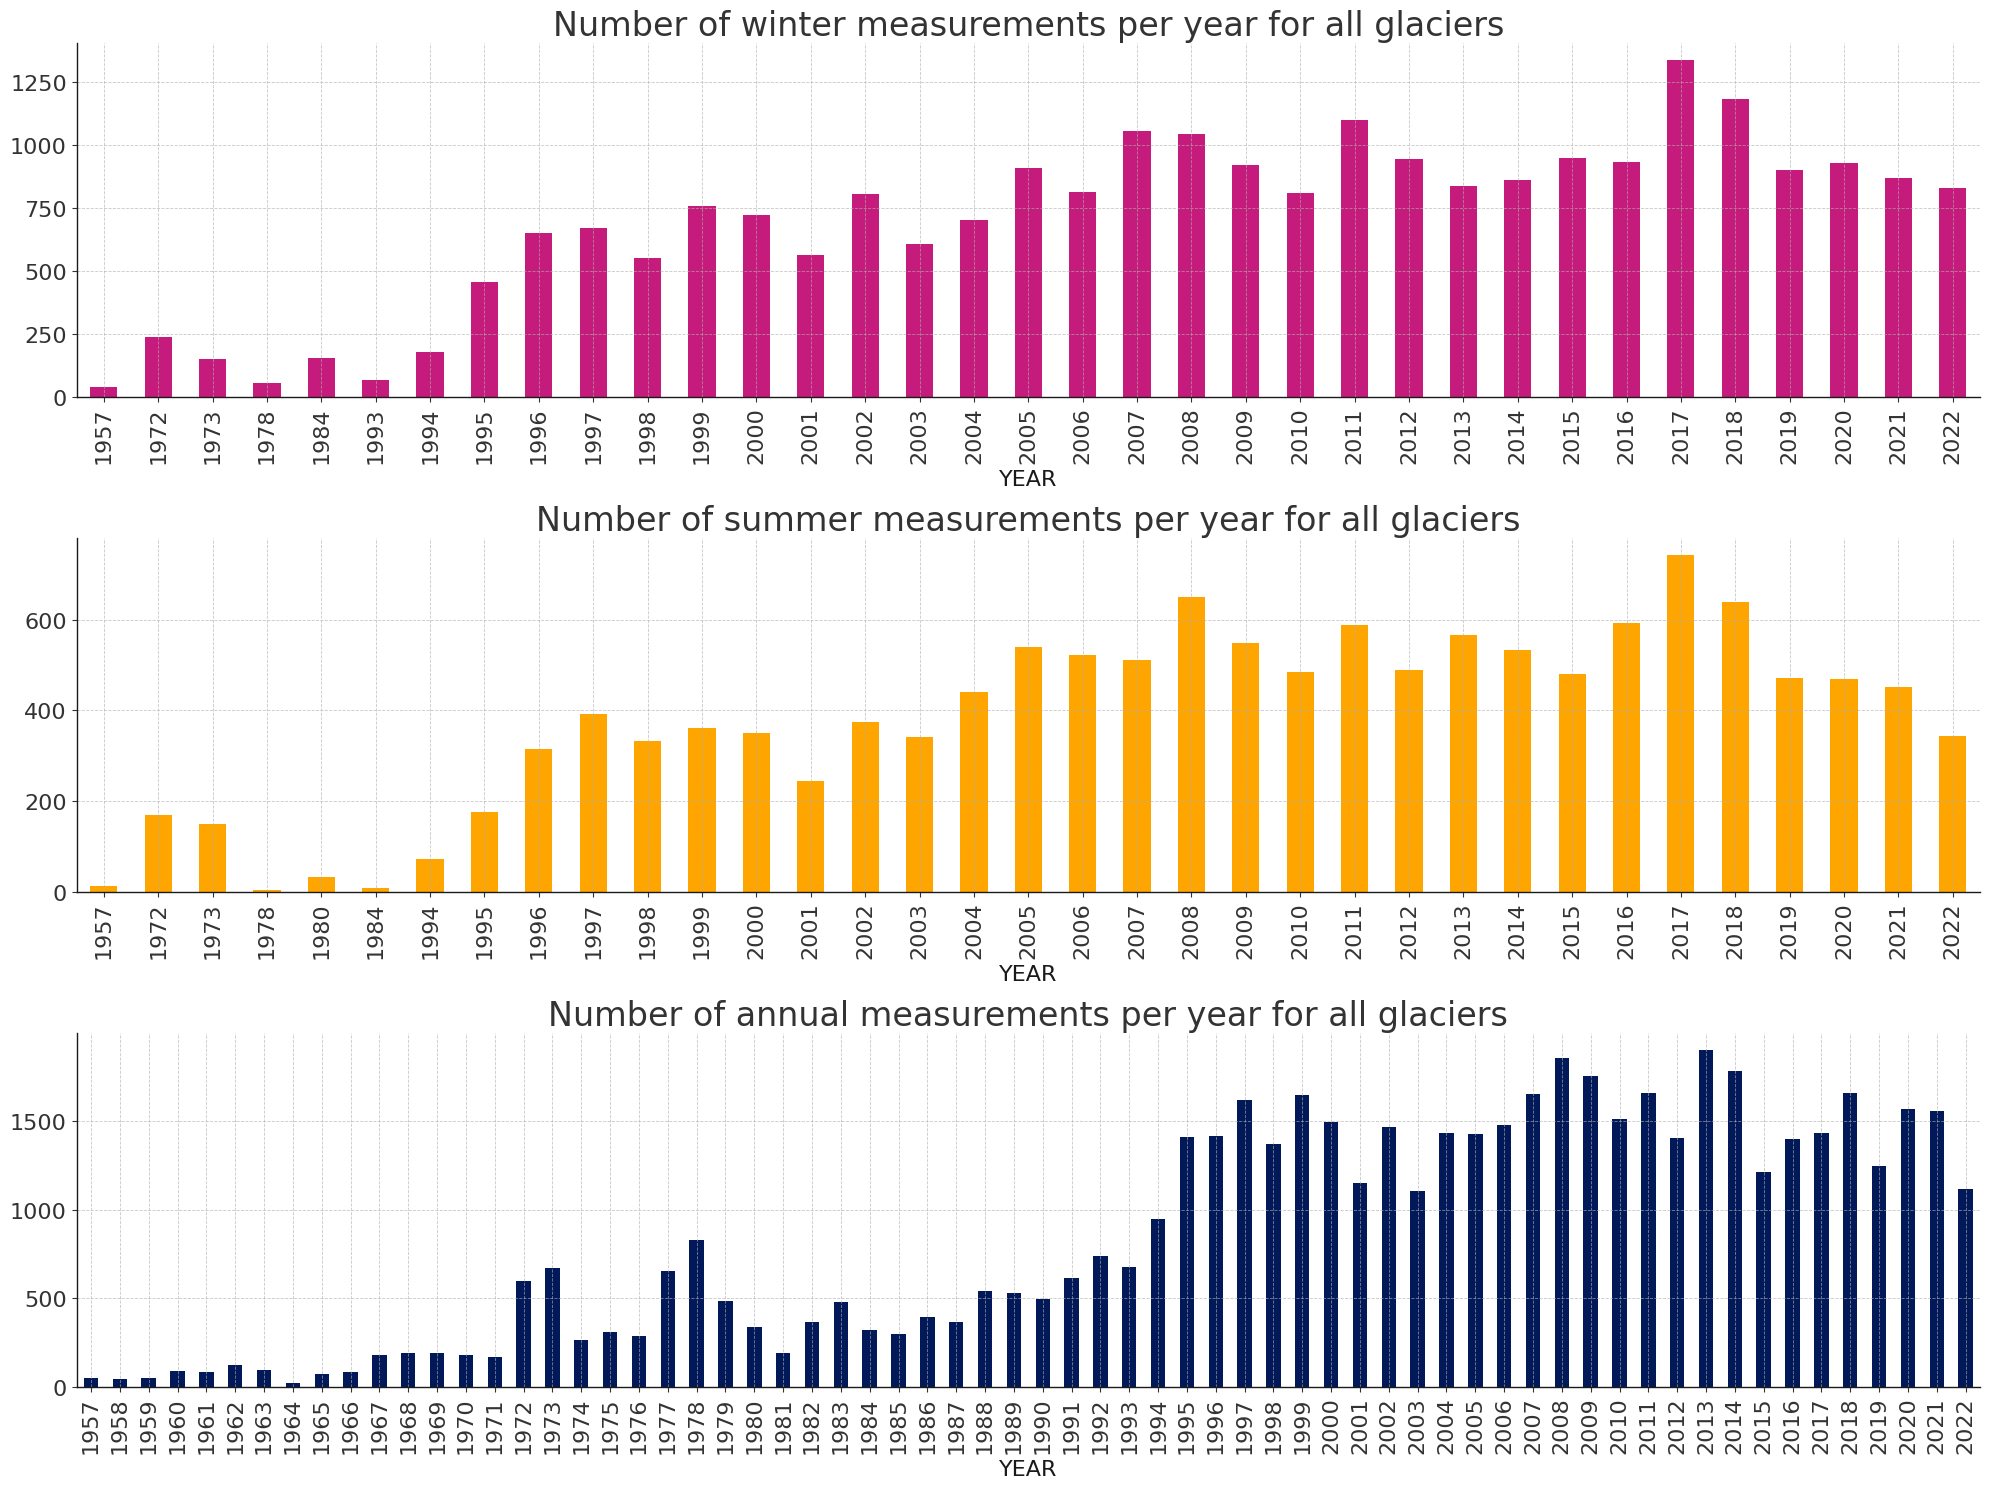

In [69]:
# Number of measurements per year:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_orange, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter, summer and annual separately:
fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharey=False)

# Winter plot
data_monthly[data_monthly.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(
        kind='bar',
        ax=axs[0],
        color=[color_pink],
        legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

# Summer plot
data_monthly[data_monthly.PERIOD == 'summer'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(
        kind='bar',
        ax=axs[1],
        color=[color_orange],
        legend=False)
axs[1].set_title('Number of summer measurements per year for all glaciers',
                 fontsize=24)

# Annual plot 
data_monthly[data_monthly.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(
        kind='bar',
        ax=axs[2], 
        color=[color_dark_blue],
        legend=False)
axs[2].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)

plt.tight_layout()

### Correction for elevation difference:

In [ ]:
"""
### NO GLOGEM DATA

# Load and preprocess GloGEM factors
path_glogem_factors = os.path.join(path_glogem, 'reference_run_GloGEM2024.csv')
glogem_factors = pd.read_csv(path_glogem_factors)
glogem_factors.rename(columns={'ID': 'RGIId'}, inplace=True)
glogem_factors['RGIId'] = glogem_factors['RGIId'].apply(
    lambda x: format_rgi_code(x))

c_prec_dic, t_off_dic = {}, {}
for gl in data_monthly.GLACIER.unique():
    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]
    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]
    c_prec_dic[gl] = factor_gl['Cprec'].values[0]
    t_off_dic[gl] = factor_gl['T_off'].values[0]

# Mean of dic values
mean_c_prec = np.max(list(c_prec_dic.values()))
mean_t_off = np.max(list(t_off_dic.values()))
print(f"Mean Cprec: {mean_c_prec}, Mean T_off: {mean_t_off}")

# Correct t2m and tp for elevation
dataloader_gl.correct_for_elevation()

# Plot the distribution of corrected and uncorrected precipitation and temperature
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Precipitation
sns.histplot(data_monthly['tp'],
             bins=50,
             kde=True,
             label='tp',
             alpha=0.5,
             ax=axes[0])
sns.histplot(data_monthly['tp_corr'],
             bins=50,
             kde=True,
             label='tp_corr',
             alpha=0.5,
             ax=axes[0])
axes[0].set_title('Distribution of Precipitation')
axes[0].set_xlabel('Precipitation (tp / tp_corr)')
axes[0].legend()

# Temperature
sns.histplot(data_monthly['t2m'],
             bins=50,
             kde=True,
             label='t2m',
             alpha=0.5,
             ax=axes[1])
sns.histplot(data_monthly['t2m_corr'],
             bins=50,
             kde=True,
             label='t2m_corr',
             alpha=0.5,
             ax=axes[1])
axes[1].set_title('Distribution of Temperature')
axes[1].set_xlabel('Temperature (t2m / t2m_corr)')
axes[1].legend()

plt.tight_layout()
plt.show()
"""

### Feature correlation:

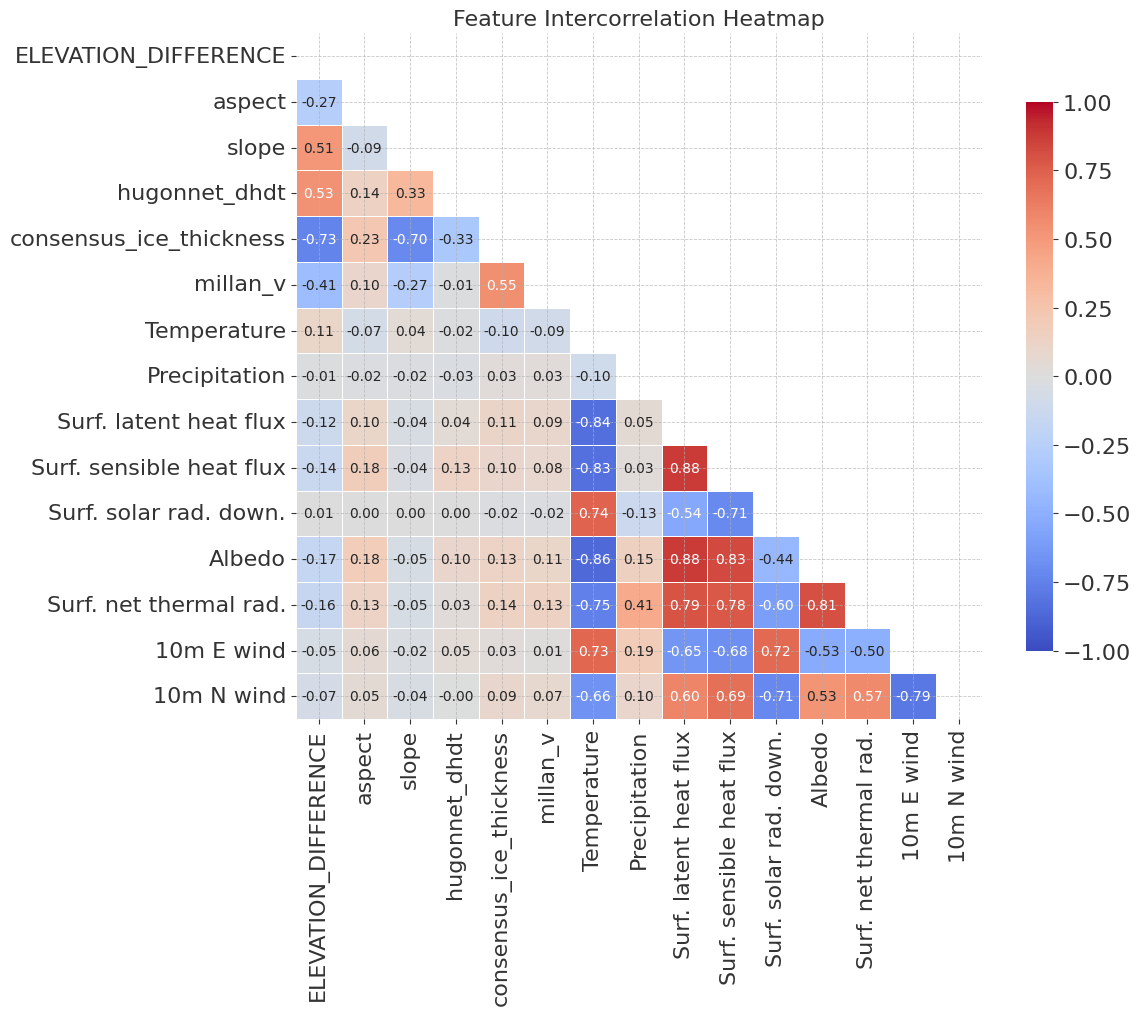

In [70]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'N_MONTHS', 'MONTHS', 'GLACIER_ZONE'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

### Sanity checks:

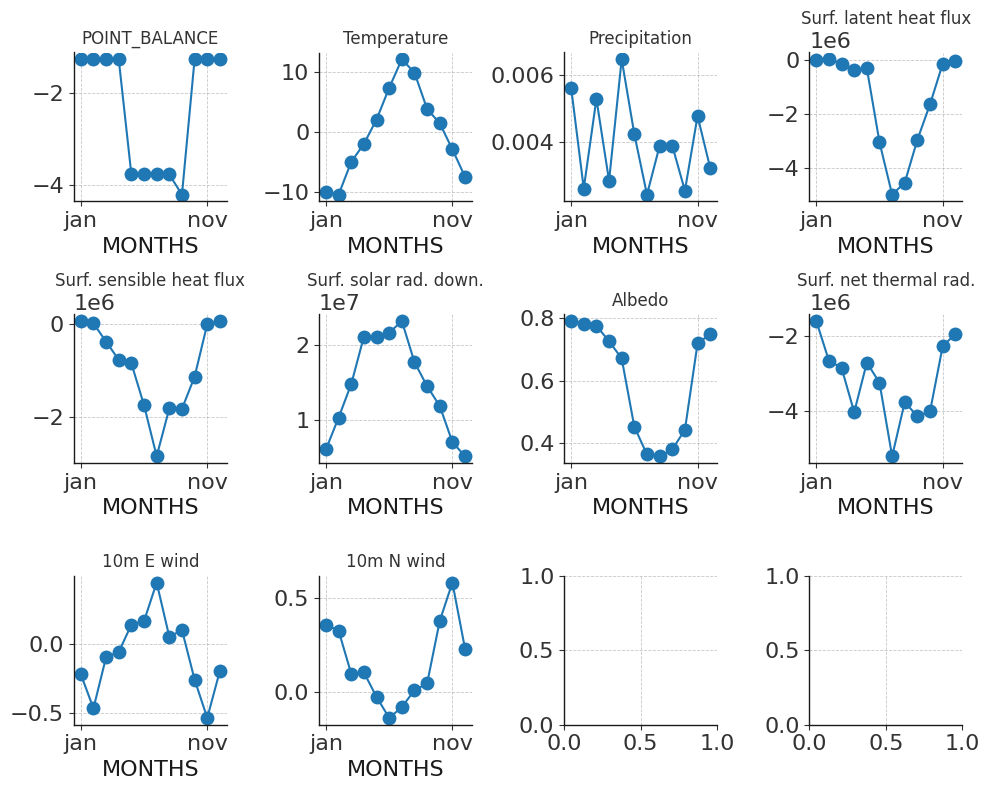

In [71]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Argentiere') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

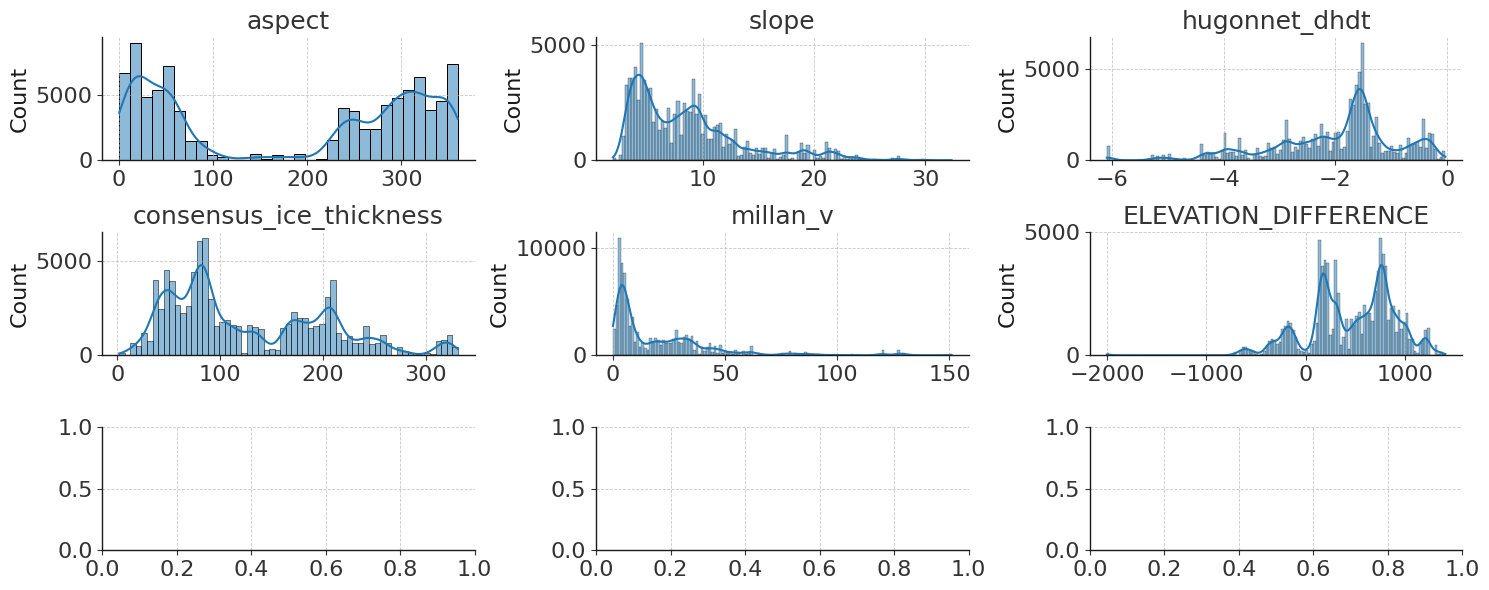

In [72]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

In [73]:
print(data_monthly['GLACIER'].unique())

['Argentiere' 'Gebroulaz' 'Grands_Montets' 'Leschaux' 'Mer_de_Glace'
 'Saint-Sorlin' 'Sarennes' 'Talefre']


## Blocking on glaciers:

In [75]:
test_glaciers = ['Leschaux']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter, summer and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_train[data_train.PERIOD == 'summer']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']
data_test_summer = data_test[data_test.PERIOD == 'summer']

print('Test:')
print('Number of winter, summer and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))
print('Number of summer samples:', len(data_test_summer))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))
print('Number of summer rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'summer']))

Size of test data: 3582
Size of train data: 89125
Percentage of test size: 4.02%
Train:
Number of winter, summer and annual samples: 89125
Number of annual samples: 52893
Number of winter samples: 23442
Number of summer samples: 12790
Test:
Number of winter, summer and annual samples: 3582
Number of annual samples: 1853
Number of winter samples: 1123
Number of summer samples: 606
Total:
Number of monthly rows: 92707
Number of annual rows: 54746
Number of winter rows: 24565
Number of summer rows: 13396


#### Heatmap annual:

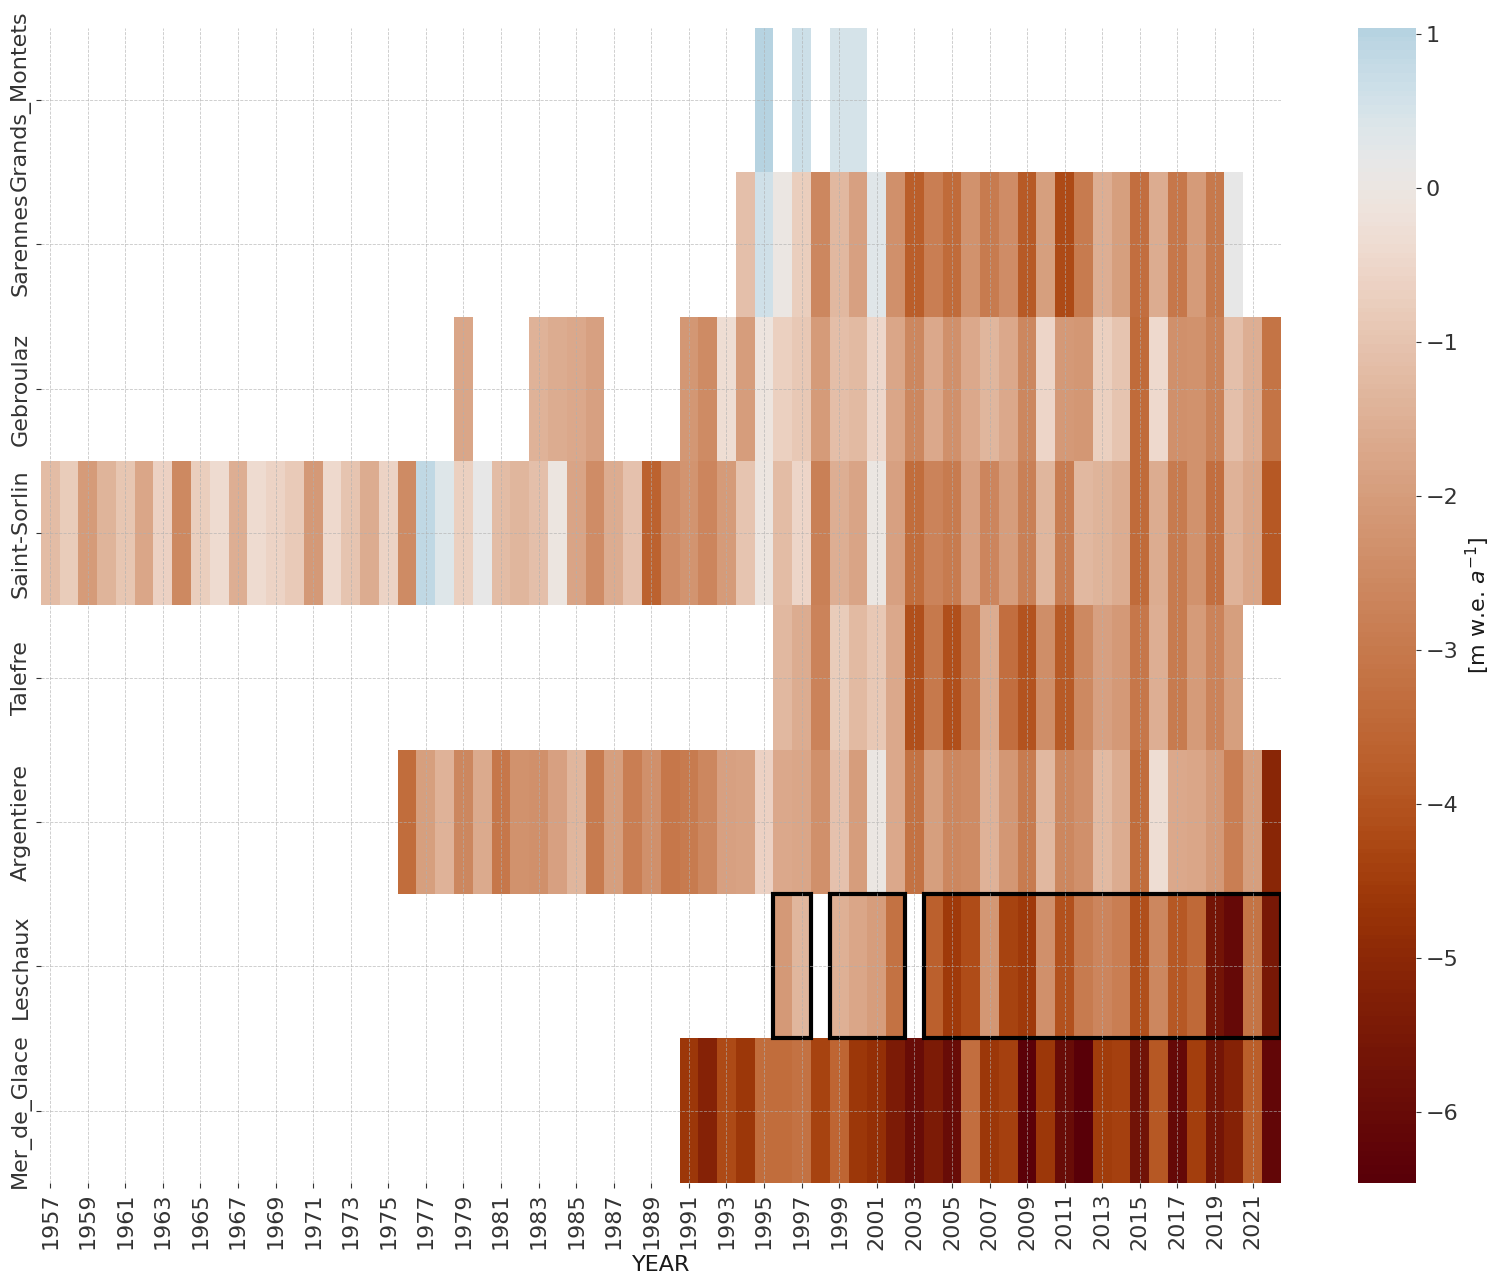

In [78]:
plotHeatmap(test_glaciers, data_glacioclim, period='annual')

#### Heatmap winter:

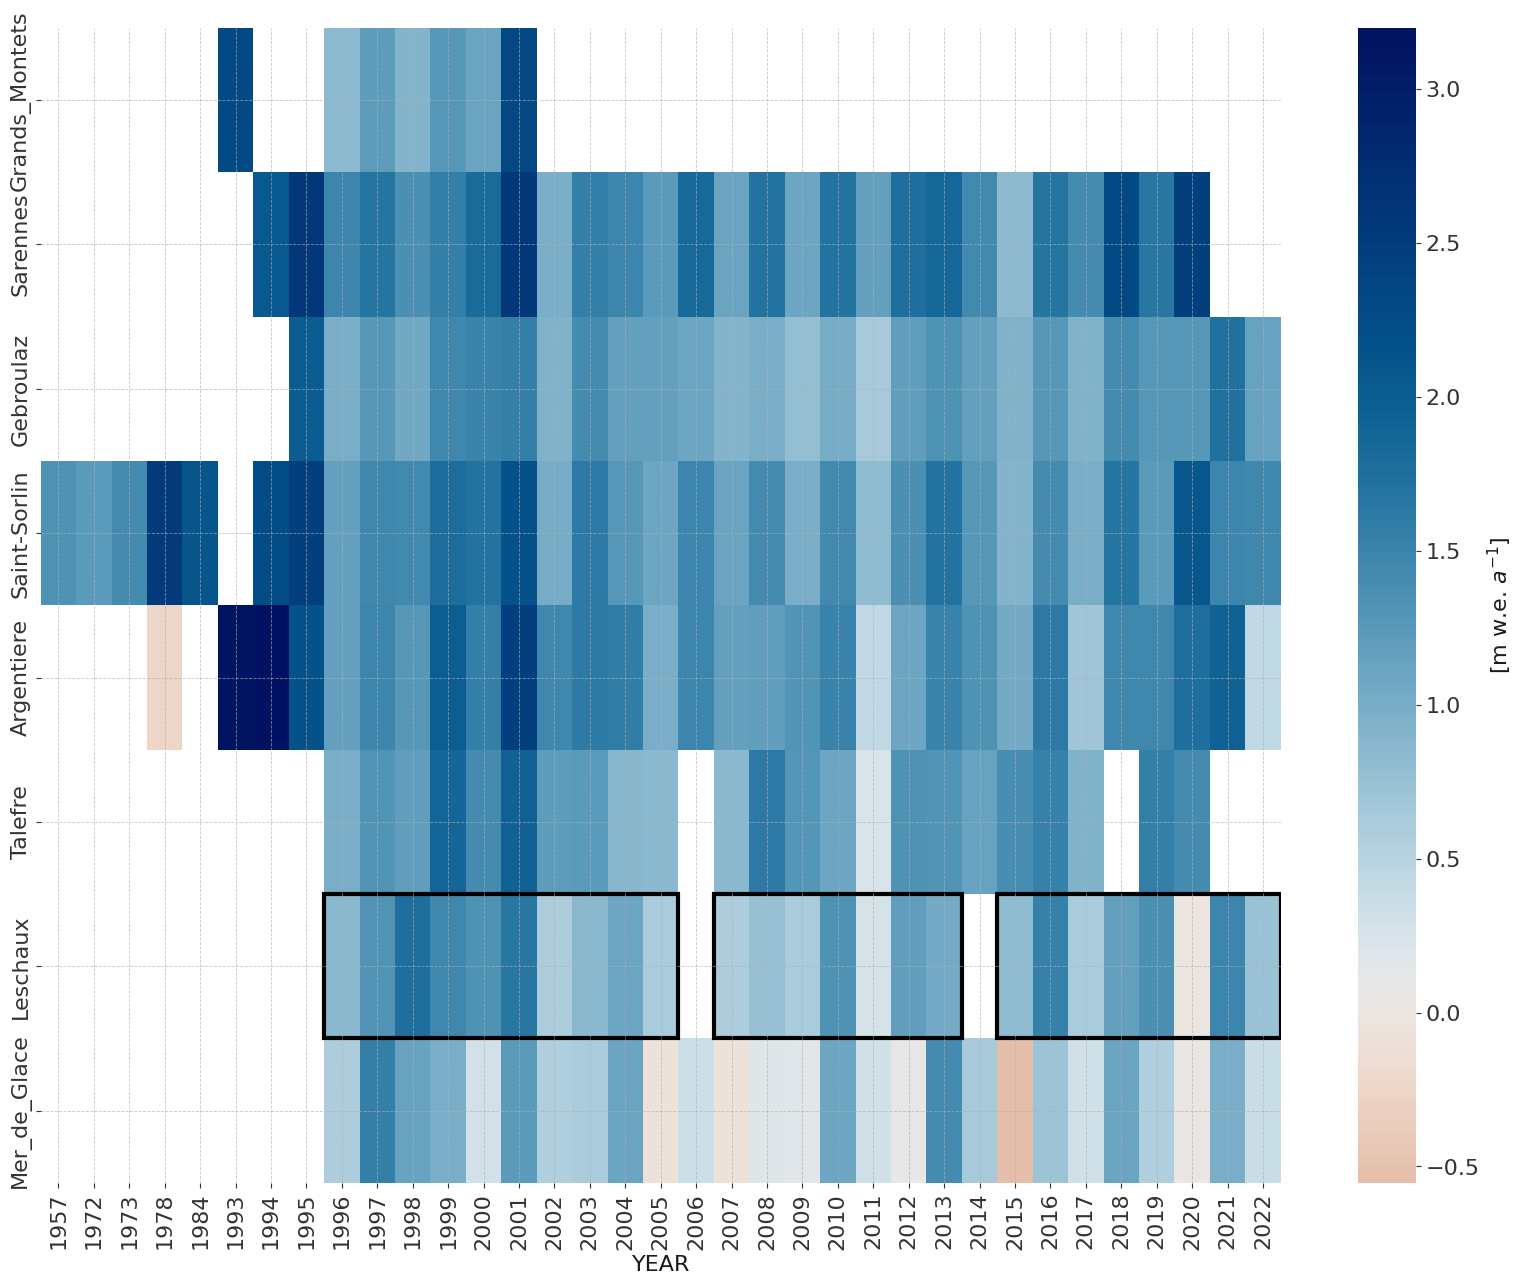

In [79]:
plotHeatmap(test_glaciers, data_glacioclim, period='winter')

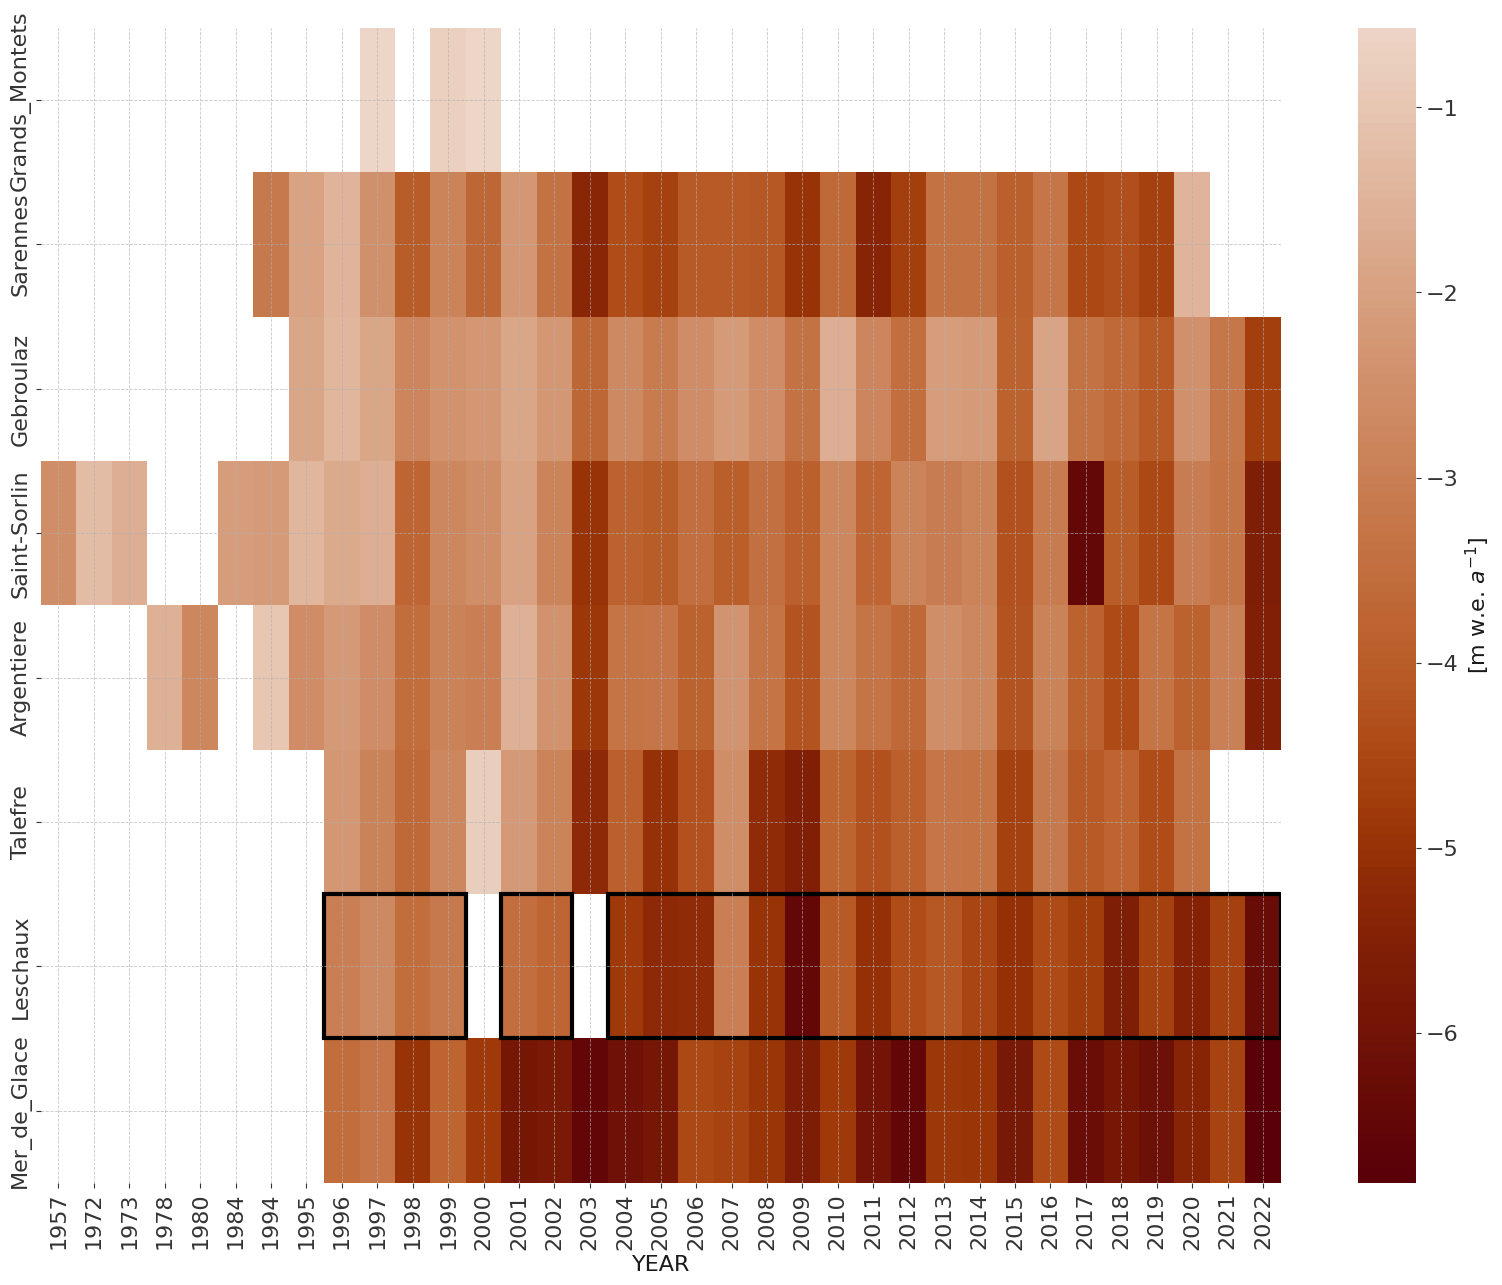

In [80]:
plotHeatmap(test_glaciers, data_glacioclim, period='summer')

#### CV splits:

Test glaciers: (1) ['Leschaux']
Percentage of test size: 4.02%
Size of test set: 3582
Train glaciers: (7) ['Argentiere' 'Gebroulaz' 'Grands_Montets' 'Mer_de_Glace' 'Saint-Sorlin'
 'Sarennes' 'Talefre']
Size of train set: 89125


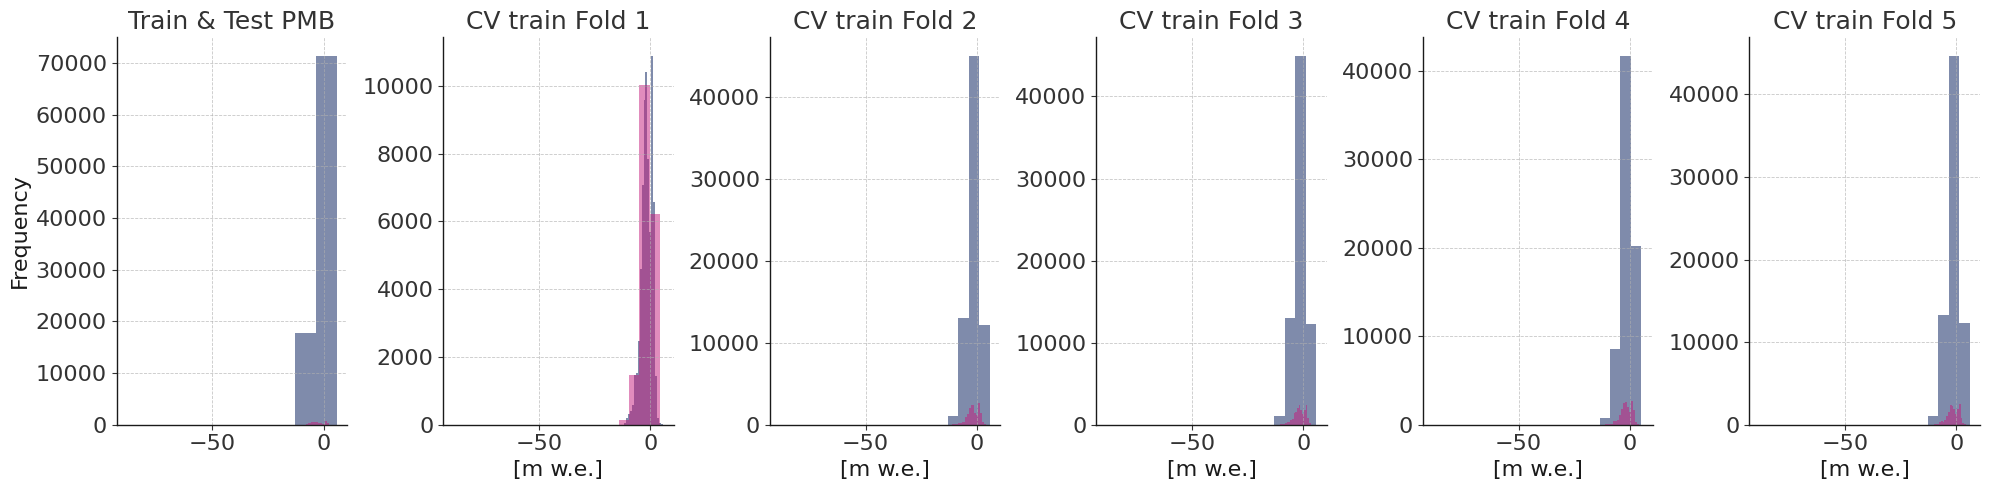

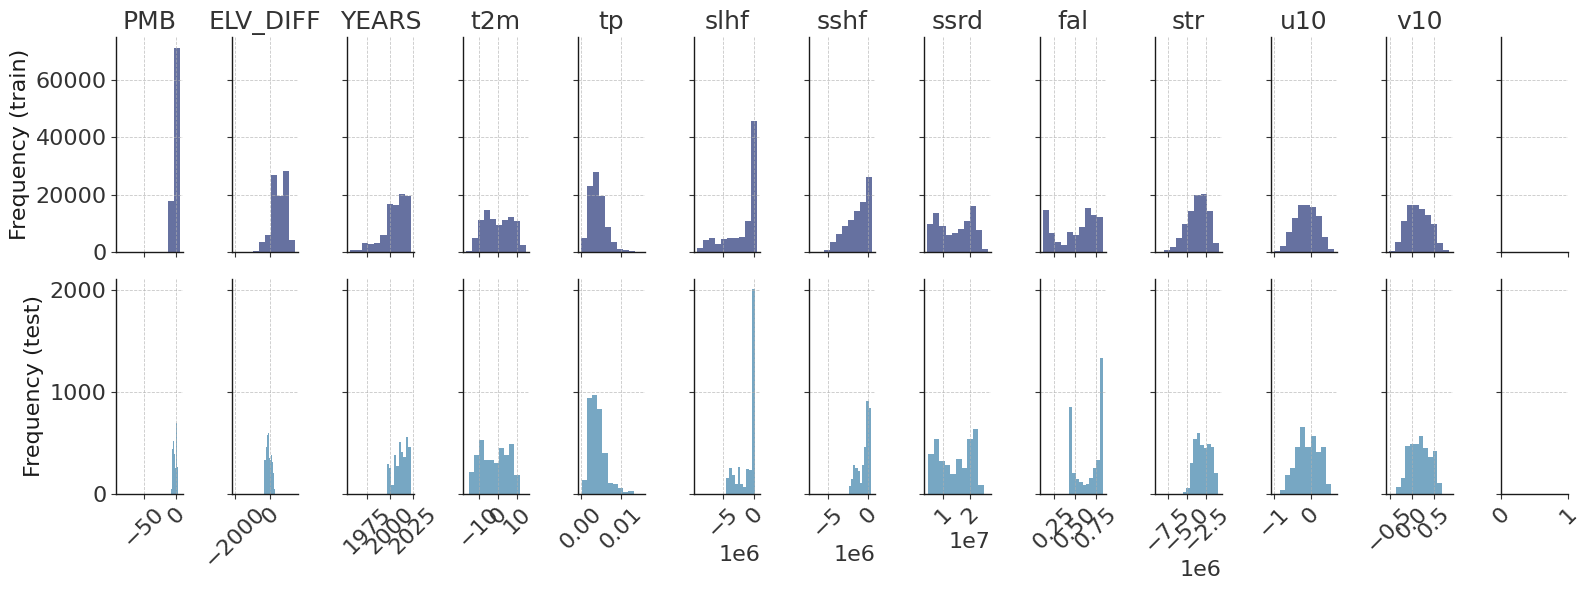

In [82]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

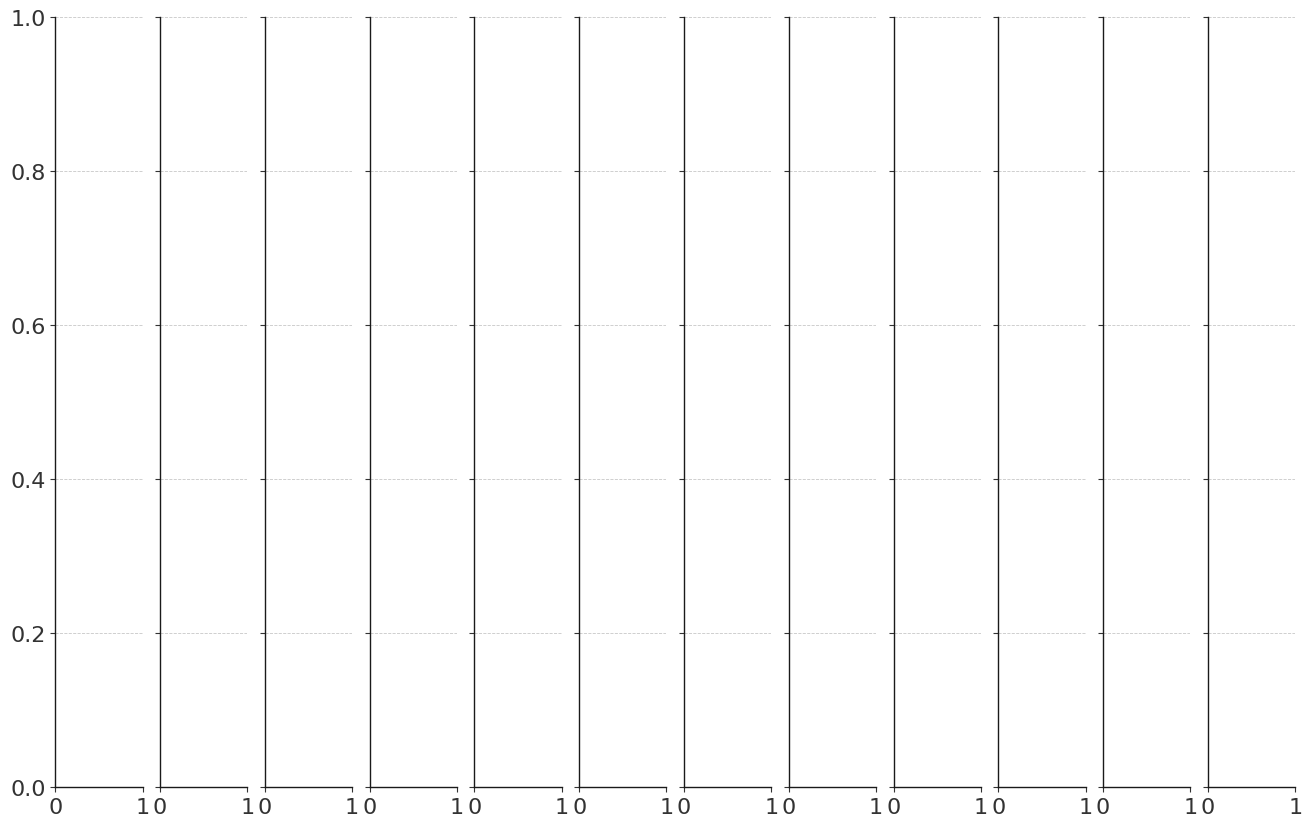

In [ ]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

TypeError: 'Axes' object is not subscriptable

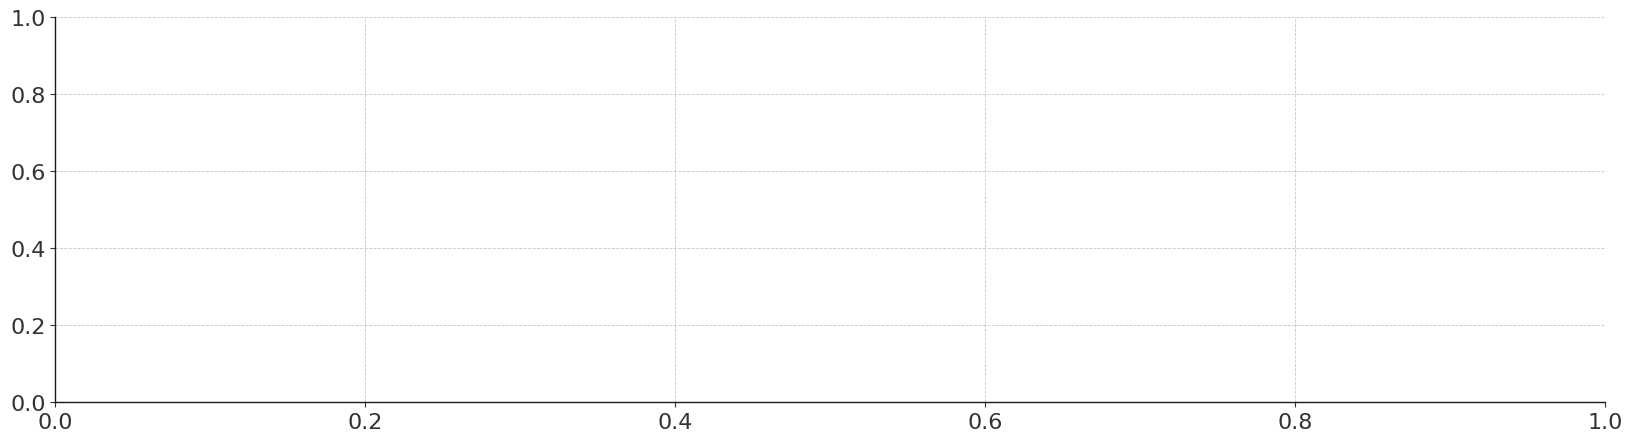

In [84]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

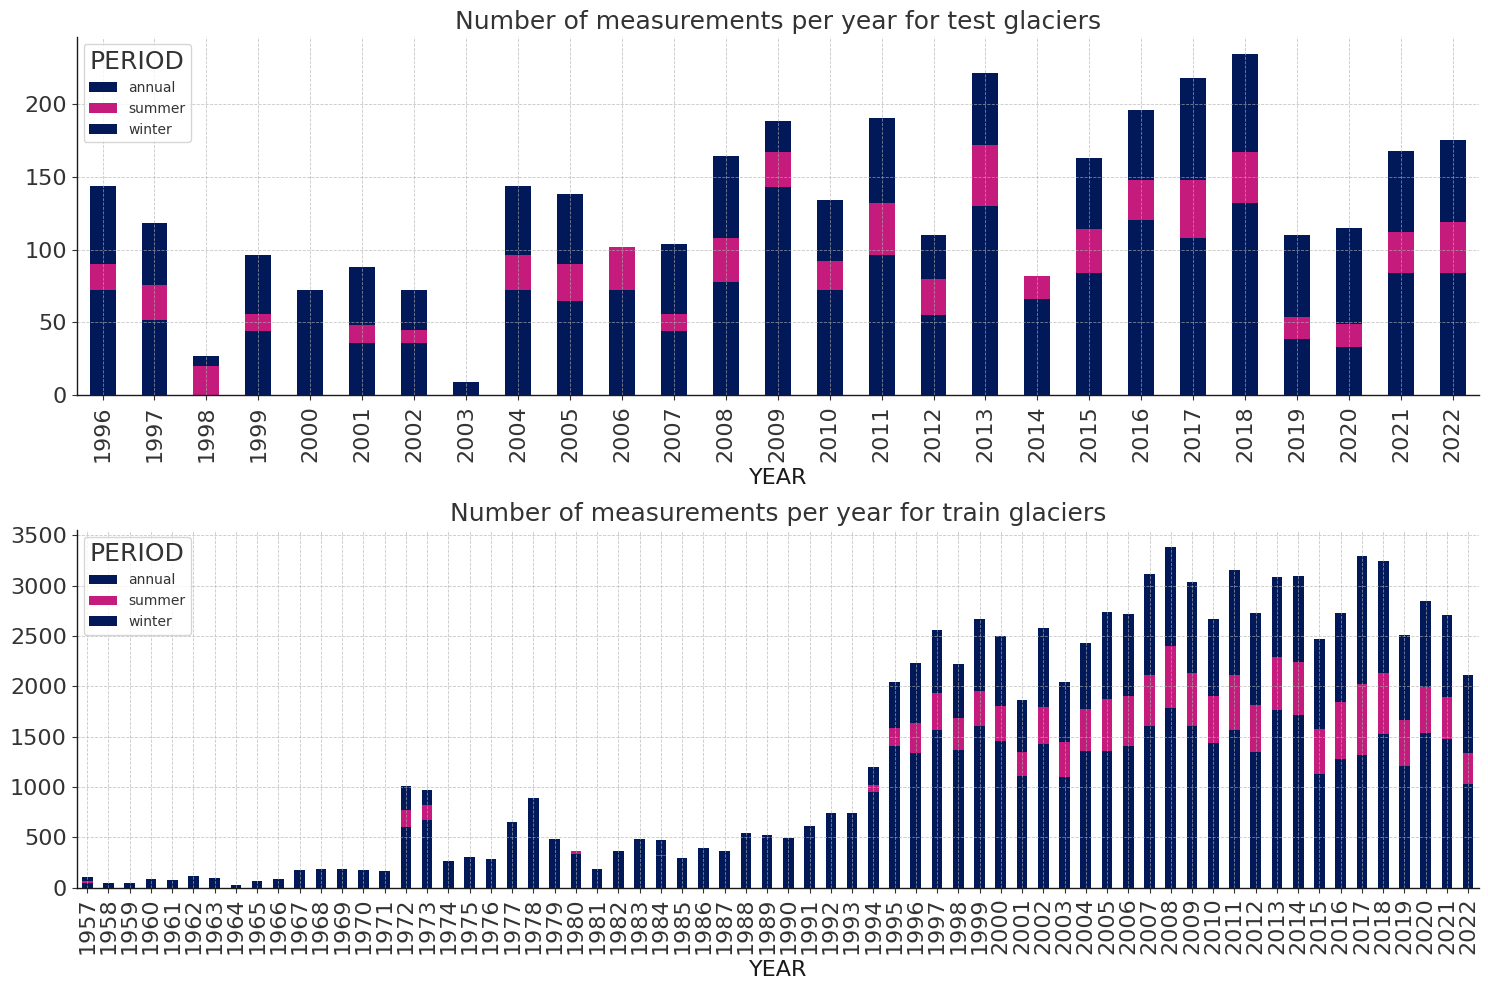

In [85]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

In [86]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

# vois_climate = [
#     't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10',
#     'v10'
# ]

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

### Grid search:

In [ ]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_gl_split_sgi_corr.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_gl_split_sgi_corr.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (89125, 27)
Shape of testing dataset: (3582, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:16:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:16:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:16:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:16:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.

Best parameters:
 {'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1}
Best score:
 -1.1479906080791051
Shape of the test: (3582, 15)
Overall score: 0.7221739163521843
CPU times: user 5min 1s, sys: 2.69 s, total: 5min 3s
Wall time: 12min 24s


In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

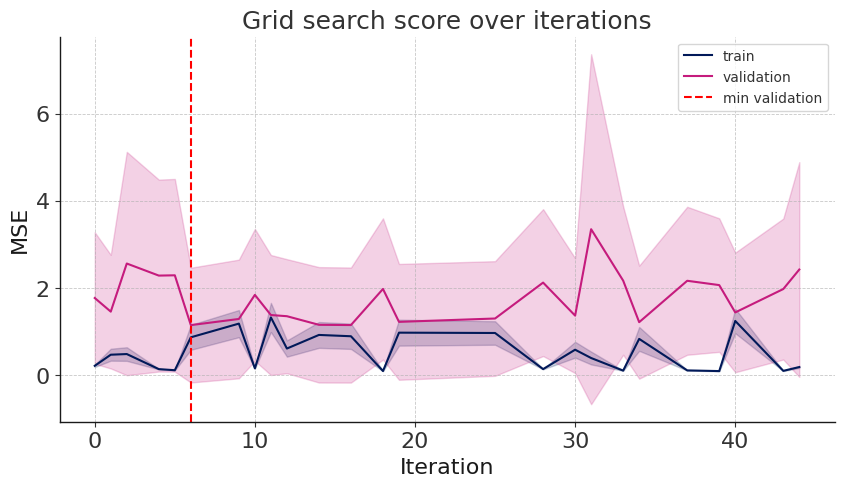

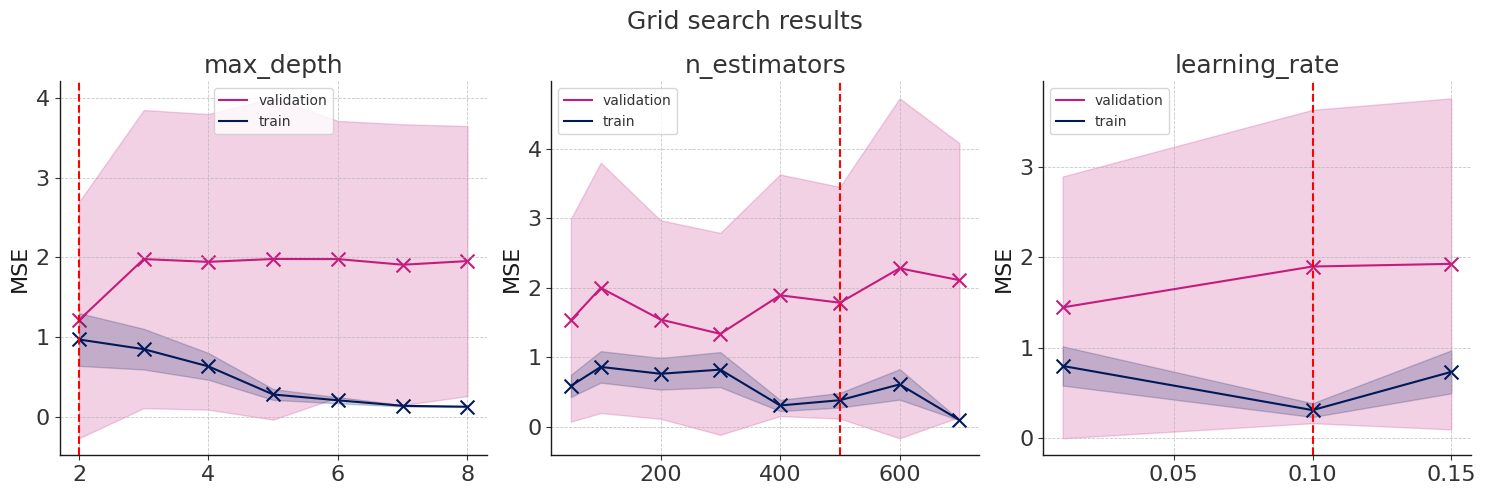

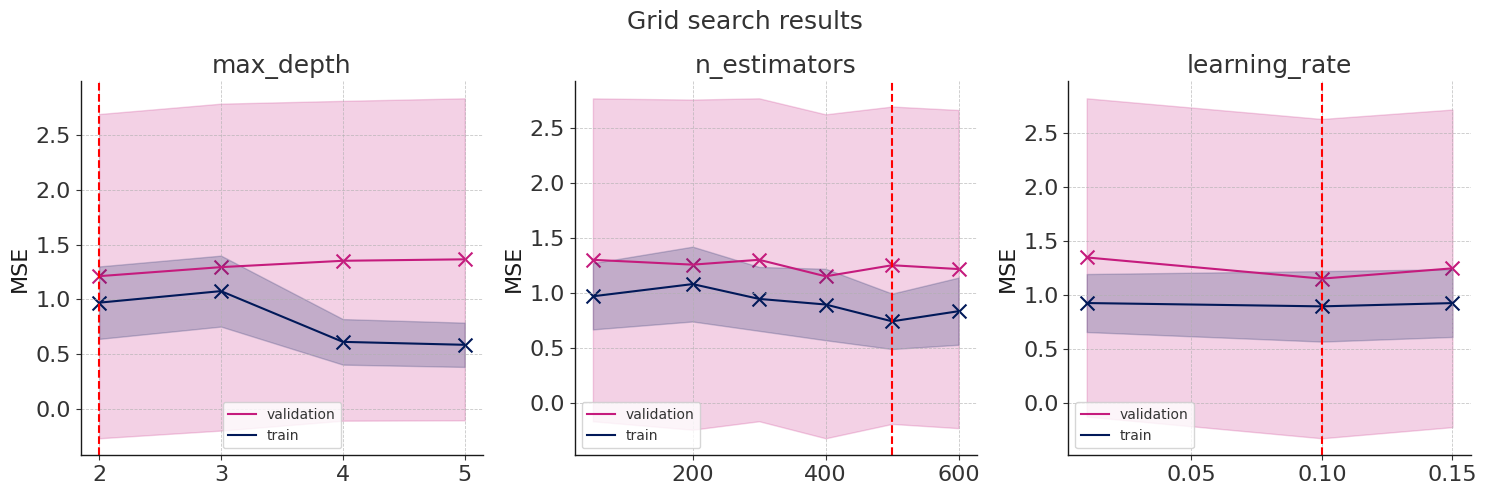

In [90]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

In [ ]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [ ]:
FIPlot(custom_model, feature_columns, vois_climate)

## Extrapolate in space


### Geodetic MB:

In [ ]:
# read geodetic MB:
geodeticMB = pd.read_csv(path_geodetic_MB_glamos + 'dV_DOI2024_allcomb.csv')

# filter to glaciers
all_gl = dataloader_gl.data.GLACIER.unique()

# get rgi of those glaciers:
rgi_gl = data_glamos[data_glamos.GLACIER.isin(all_gl)].RGIId.unique()
sgi_gl = [
    rgi_df[rgi_df['rgi_id.v6'] == rgi]['sgi-id'].values[0] for rgi in rgi_gl
]
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Add glacierName to geodeticMB
# based  on SGI-ID
glacierNames = [
    rgi_df[rgi_df['sgi-id'] == sgi_id].index[0]
    for sgi_id in geodeticMB['SGI-ID'].values
]
geodeticMB['glacierName'] = glacierNames

# replace claridenL by clariden
geodeticMB['glacierName'] = geodeticMB['glacierName'].apply(
    lambda x: 'clariden' if x == 'claridenL' else x)

# get years per glacier
years_start_per_gl = geodeticMB.groupby(
    'glacierName')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodeticMB.groupby('glacierName')['A_end'].unique().apply(
    list).to_dict()

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)
# Iterate through the DataFrame rows
for _, row in geodeticMB.iterrows():
    glacierName = row['glacierName']
    start_year = row['Astart']
    end_year = row['A_end']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    periods_per_glacier[glacierName].append((start_year, end_year))
    geoMB_per_glacier[glacierName].append(geoMB)

### Glacier wide MB: 
Compute 2D fields.

#### List of glaciers to compute:

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

satellite_glaciers = [
    'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
    'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
    'schwarzbach', 'schwarzberg'
]
geodetic_glaciers = geodeticMB.glacierName.unique()
print('Number of glaciers with geodetic MB:', len(geodetic_glaciers))

# Intersection of both
common_glaciers = list(set(geodetic_glaciers) & set(glacier_list))
print('Number of common glaciers:', len(common_glaciers))

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(common_glaciers, gl_area)
glacier_list

### GLAMOS grids:

### Normal T & P:

In [ ]:
RUN = True
if RUN:
    # Define paths
    path_save_glw = 'results/nc/glamos/OGGM_vars/TP_T2m/'
    path_xr_grids = '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/topo/GLAMOS_DEM/xr_masked_grids/'  # GLAMOS DEMs

    emptyfolder(path_save_glw)

    # Feature columns
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical)
    all_columns = feature_columns + cfg.fieldsNotFeatures
    print('Running for feature columns:', all_columns)

    for glacier_name in glacier_list:
        glacier_path = os.path.join(path_glacier_grid_glamos, glacier_name)

        if not os.path.exists(glacier_path):
            print(f"Folder not found for {glacier_name}, skipping...")
            continue

        glacier_files = sorted(
            [f for f in os.listdir(glacier_path) if glacier_name in f])

        print(f"Processing {glacier_name} ({len(glacier_files)} files)")

        for file_name in tqdm(glacier_files,
                              desc=f"Processing {glacier_name}",
                              leave=False):
            year = int(file_name.split('_')[2].split('.')[0])
            # process_glacier_file(cfg, custom_model, glacier_name, file_name,
            #                      path_save_glw, path_xr_grids, all_columns)

            # Load parquet input glacier grid file in monthly format (pre-processed)
            df_grid_monthly = pd.read_parquet(
                os.path.join(path_glacier_grid_glamos, glacier_name,
                             file_name))
            df_grid_monthly.drop_duplicates(inplace=True)

            # Keep only necessary columns, avoiding missing columns issues
            df_grid_monthly = df_grid_monthly[[
                col for col in all_columns if col in df_grid_monthly.columns
            ]]

            # Create geodata object
            geoData = mbm.GeoData(df_grid_monthly)

            # Computes and saves gridded MB for a year and glacier
            geoData.gridded_MB_pred(custom_model,
                                    glacier_name,
                                    year,
                                    all_columns,
                                    path_xr_grids,
                                    path_save_glw,
                                    cfg,
                                    save_monthly_pred=True)


In [ ]:
glacier_name = 'clariden'
year = 1951
# open xarray
xr.open_dataset(
    path_save_glw +
    f'{glacier_name}/{glacier_name}_{year}_annual.zarr').pred_masked.plot()